In [ ]:
# Figures

# Figures

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap

### 6D

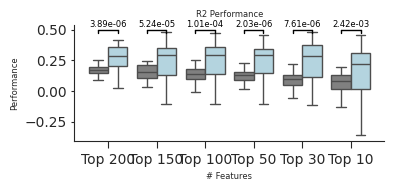

In [5]:
base_dirs_original = [
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung1/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung2/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung3/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung4/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung5/models/XGB/cnmf_top_25/'
]


base_dirs_bulk = [
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung_bulk1/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung_bulk2/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung_bulk3/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung_bulk4/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung_bulk5/models/XGB/cnmf_top_25/'
]

from scipy.stats import ranksums

m_values = list(range(1, 196, 5))
m_labels = {m: "Top " + str(196 - m) for m in m_values}
m_labels['test_set'] = 'Top 200'

sns.set_style("white")

def collect_performance_data(base_dirs, label_prefix):
    performance_data = []
    for base_dir in base_dirs:
        for seed_folder in os.listdir(base_dir):
            if seed_folder.startswith('seed_') and os.path.isdir(os.path.join(base_dir, seed_folder)):
                seed_path = os.path.join(base_dir, seed_folder, 'backwards_elimination_results')

                for m in m_values:
                    file_path = os.path.join(seed_path, f'model_iteration_{m}_feature_importance_permutation_importance_test_performance.txt')
                    if os.path.isfile(file_path):
                        with open(file_path, 'r') as file:
                            performance = float(file.readline().strip())
                            label = m_labels.get(m, None)
                            if label:
                                performance_data.append([seed_folder, label, performance, label_prefix])

                # Collect data from test_set_performance.txt
                test_set_performance_file = os.path.join(base_dir, seed_folder, 'test_set_performance.txt')
                if os.path.isfile(test_set_performance_file):
                    with open(test_set_performance_file, 'r') as file:
                        test_performance = float(file.readline().strip())
                        performance_data.append([seed_folder, m_labels['test_set'], test_performance, label_prefix])
    return performance_data

performance_data_bulk = collect_performance_data(base_dirs_bulk, 'bulk')
performance_data_original = collect_performance_data(base_dirs_original, 'original')
performance_data_combined = performance_data_bulk + performance_data_original


performance_df = pd.DataFrame(performance_data_combined, columns=['Seed', 'Features', 'Performance', 'Dataset'])

#feature_order = ["Top 200", "Top 175", "Top 150", "Top 125", "Top 100", "Top 75", "Top 50", "Top 25", "Top 10"]
feature_order = ["Top 200", "Top 150", "Top 100", "Top 50", "Top 30", "Top 10"]


performance_df = performance_df[performance_df['Features'].isin(feature_order)]
performance_df['Features'] = pd.Categorical(performance_df['Features'], categories=feature_order, ordered=True)

# Calculate p-values using Wilcoxon rank-sum test
p_values = {}
for feature in feature_order:
    bulk_data = performance_df[(performance_df['Features'] == feature) & (performance_df['Dataset'] == 'bulk')]['Performance']
    original_data = performance_df[(performance_df['Features'] == feature) & (performance_df['Dataset'] == 'original')]['Performance']
    p_value = ranksums(bulk_data, original_data).pvalue
    p_values[feature] = p_value

# Plotting
plt.figure(figsize=(4, 1.5))
ax = sns.boxplot(data=performance_df, x='Features', y='Performance', hue='Dataset', showfliers=False, palette={'original': 'lightblue', 'bulk': 'gray'})

# Annotate plot with p-values and draw lines
y_max = performance_df['Performance'].max()
y_offset = 0.01  # Offset for the annotation lines and text

for i, feature in enumerate(feature_order):
    p_value = p_values[feature]
    p_value_text = f"{p_value:.2e}" if p_value < 0.05 else f"{p_value:.2f}"
    
    # Position for the p-value text and line
    x1, x2 = i - 0.2, i + 0.2
    y = y_max + y_offset
    
    # Draw a line between the box plots
    ax.plot([x1, x2], [y, y], lw=1, color='black')
    
    # Add small vertical lines at the ends of the horizontal line
    ax.plot([x1, x1], [y, y - 0.02], lw=1, color='black')  # Left vertical line
    ax.plot([x2, x2], [y, y - 0.02], lw=1, color='black')  # Right vertical line
    
    # Add p-value text
    ax.text(i, y + y_offset, p_value_text, ha='center', va='bottom', fontsize=6, color='black')


plt.gca().tick_params(axis='both', which='both', length=5)  # Customize tick length if needed

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.tick_params(axis='x', which='both', bottom=True, top=False, direction='out', length=5)
plt.tick_params(axis='y', which='both', left=True, right=False, direction='out', length=2)
sns.despine()
plt.xlabel('# Features', fontsize=6)
plt.ylabel('Performance', fontsize=6) 
plt.title('R2 Performance', fontsize=6)
plt.xticks(rotation=0) 
plt.legend().remove()
plt.savefig("/sc/arion/work/kimg20/aging/performance.pdf", format="pdf")

plt.show()

### 6E

In [63]:
base_dirs = [
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung1/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung2/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung3/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung4/models/XGB/cnmf_top_25/',
    '/sc/arion/projects/Tsankov_Normal_Lung/kimg20/240821/7rarenewfeatures/lung5/models/XGB/cnmf_top_25/'
]



all_data = []

for base_dir in base_dirs:
    for seed_folder in os.listdir(base_dir):
        if seed_folder.startswith('seed_') and os.path.isdir(os.path.join(base_dir, seed_folder)):
            seed_path = os.path.join(base_dir, seed_folder, 'backwards_elimination_results')
            #print(f"Processing seed folder: {seed_path}")

            starter_model_file = os.path.join(seed_path, 'top_features_iteration_166_by_permutation_importance.txt')
            # starter_model_top_features_by_permutation_importance is top200
            # top_features_iteration_46_by_permutation_importance is top150
            # top_features_iteration_96_by_permutation_importance is top100
            # top_features_iteration_146_by_permutation_importance is top50
            # top_features_iteration_171_by_permutation_importance top25
            # top_features_iteration_166_by_permutation_importance top30
            if os.path.isfile(starter_model_file):
                with open(starter_model_file, 'r') as file:
                    data = file.readlines()
                    for line in data:
                        rank, feature = line.strip().split('. ')
                        all_data.append([seed_folder, 'starter_model', int(rank), feature])

df = pd.DataFrame(all_data, columns=['Seed', 'Iteration', 'Rank', 'Feature'])

# counts
feature_counts = df['Feature'].value_counts().reset_index()
feature_counts.columns = ['Feature', 'Count']

top_50_features = feature_counts.head(25)

/tmp/ipykernel_265063/2281631844.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_50_features['CN'] = top_50_features['Feature'].apply(lambda x: x.split('_')[0])
/tmp/ipykernel_265063/2281631844.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_50_features['CellType'] = top_50_features['Feature'].apply(lambda x: x.split('_')[1])
/tmp/ipykernel_265063/2281631844.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

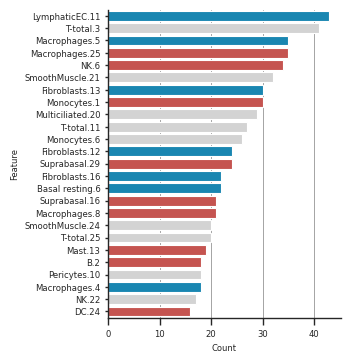

In [11]:
plt.rcParams.update({'font.size': 6})

top_50_features['CN'] = top_50_features['Feature'].apply(lambda x: x.split('_')[0])
top_50_features['CellType'] = top_50_features['Feature'].apply(lambda x: x.split('_')[1])
top_50_features['Feature'] = top_50_features['Feature'].apply(lambda x: f"{x.split('_')[1]}.{x.split('_')[0][2:]}")


colors = []
sns.set_context("paper", font_scale=0.7) 
data_mean_dir = '/sc/arion/work/kimg20/aging/ml/HLCA_cpdb_lvl_2.5_uniform_v4_CNMF_nonunique_Full_FDR_celltype/'

for index, row in top_50_features.iterrows():
    cell_type = row['CellType']
    cn = row['CN']

    filename = f"Pseudobulk_HLCA_Full_{cell_type}_per_sample_perCNMF_spearman_correlation_top25.csv"
    file_path = os.path.join(data_mean_dir, filename)

    if os.path.isfile(file_path):
        df = pd.read_csv(file_path, index_col=0)

        p_value = df.loc['p.value', cn]
        correlation_rho = df.loc['correlation.rho', cn]

        if p_value < 0.05:
            if correlation_rho > 0:
                colors.append('#D8423D') 
            else:
                colors.append('#0091CA') 
        else:
            colors.append('#D3D3D3') 
    else:
        colors.append('#D6D6D6')


plt.figure(figsize=(3, 4))
sns.set_style("white")

sns.barplot(x='Count', y='Feature', data=top_50_features, palette=colors)

#plt.title('# Features Appearance - Top 200 Features')
plt.xlabel('Count', fontsize=6)
plt.ylabel('Feature', fontsize=6)

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.tick_params(axis='x', which='both', bottom=True, top=False, direction='out', length=5)
plt.tick_params(axis='y', which='both', left=True, right=False, direction='out', length=2)

plt.grid(True, axis='x', which='both', color='gray', linestyle='-', linewidth=0.5)

#plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))  # Customize as per your tick marks
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(10))  # Customize as per your major ticks
sns.despine(top=True, right=True)

plt.savefig("/sc/arion/work/kimg20/aging/top_30_25.pdf", format="pdf")
plt.show()

### S6A

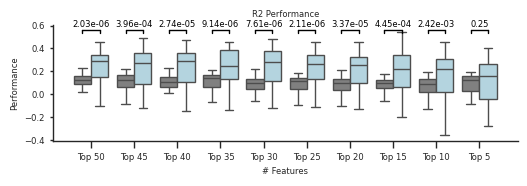

In [91]:
from scipy.stats import ranksums

m_values = list(range(1, 196, 5))
m_labels = {m: "Top " + str(196 - m) for m in m_values}
m_labels['test_set'] = 'Top 200'

sns.set_style("white")

def collect_performance_data(base_dirs, label_prefix):
    performance_data = []
    for base_dir in base_dirs:
        for seed_folder in os.listdir(base_dir):
            if seed_folder.startswith('seed_') and os.path.isdir(os.path.join(base_dir, seed_folder)):
                seed_path = os.path.join(base_dir, seed_folder, 'backwards_elimination_results')

                for m in m_values:
                    file_path = os.path.join(seed_path, f'model_iteration_{m}_feature_importance_permutation_importance_test_performance.txt')
                    if os.path.isfile(file_path):
                        with open(file_path, 'r') as file:
                            performance = float(file.readline().strip())
                            label = m_labels.get(m, None)
                            if label:
                                performance_data.append([seed_folder, label, performance, label_prefix])

                test_set_performance_file = os.path.join(base_dir, seed_folder, 'test_set_performance.txt')
                if os.path.isfile(test_set_performance_file):
                    with open(test_set_performance_file, 'r') as file:
                        test_performance = float(file.readline().strip())
                        performance_data.append([seed_folder, m_labels['test_set'], test_performance, label_prefix])
    return performance_data

performance_data_bulk = collect_performance_data(base_dirs_bulk, 'bulk')
performance_data_original = collect_performance_data(base_dirs_original, 'original')
performance_data_combined = performance_data_bulk + performance_data_original


performance_df = pd.DataFrame(performance_data_combined, columns=['Seed', 'Features', 'Performance', 'Dataset'])

feature_order = ["Top 50", "Top 45", "Top 40", "Top 35", "Top 30", "Top 25", "Top 20", "Top 15", "Top 10", "Top 5",]

performance_df = performance_df[performance_df['Features'].isin(feature_order)]
performance_df['Features'] = pd.Categorical(performance_df['Features'], categories=feature_order, ordered=True)

p_values = {}
for feature in feature_order:
    bulk_data = performance_df[(performance_df['Features'] == feature) & (performance_df['Dataset'] == 'bulk')]['Performance']
    original_data = performance_df[(performance_df['Features'] == feature) & (performance_df['Dataset'] == 'original')]['Performance']
    p_value = ranksums(bulk_data, original_data).pvalue
    p_values[feature] = p_value

plt.figure(figsize=(6, 1.5))
ax = sns.boxplot(data=performance_df, x='Features', y='Performance', hue='Dataset', showfliers=False, palette={'original': 'lightblue', 'bulk': 'gray'})

y_max = performance_df['Performance'].max()
y_offset = 0.01  

for i, feature in enumerate(feature_order):
    p_value = p_values[feature]
    p_value_text = f"{p_value:.2e}" if p_value < 0.05 else f"{p_value:.2f}"
    
    x1, x2 = i - 0.2, i + 0.2
    y = y_max + y_offset
    
    ax.plot([x1, x2], [y, y], lw=1, color='black')
    
    ax.plot([x1, x1], [y, y - 0.02], lw=1, color='black')  # Left vertical line
    ax.plot([x2, x2], [y, y - 0.02], lw=1, color='black')  # Right vertical line
        ax.text(i, y + y_offset, p_value_text, ha='center', va='bottom', fontsize=6, color='black')


plt.gca().tick_params(axis='both', which='both', length=5) 

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.tick_params(axis='x', which='both', bottom=True, top=False, direction='out', length=5)
plt.tick_params(axis='y', which='both', left=True, right=False, direction='out', length=2)
sns.despine()
plt.xlabel('# Features', fontsize=6)
plt.ylabel('Performance', fontsize=6) 
plt.title('R2 Performance', fontsize=6)
plt.xticks(rotation=0) 
plt.legend().remove()
plt.savefig("/sc/arion/work/kimg20/aging/performance_supp.pdf", format="pdf")

plt.show()

### S6B

Skipping file for cell type: HSC
Skipping file for cell type: Goblet
Skipping file for cell type: Hillock-like
Skipping file for cell type: Mesothelium
Skipping file for cell type: PNEC
Skipping file for cell type: Tuft
Skipping file for cell type: Ionocyte
               Category  Proportion
0  Significant_Positive    0.074016
1  Significant_Negative    0.111811
2       Non-significant    0.814173
               Category  Proportion
0  Significant_Positive        0.36
1  Significant_Negative        0.28
2       Non-significant        0.36
General positive significant count: 47
General negative significant count: 71
General non-significant count: 517
Top50 positive significant count: 9
Top50 negative significant count: 7
Top50 non-significant count: 9


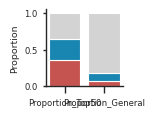

In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_mean_dir = '/sc/arion/work/kimg20/aging/ml/HLCA_cpdb_lvl_2.5_uniform_v4_CNMF_nonunique_Full_FDR_celltype/'


skip_cell_types = ['HSC', 'Ionocyte', 'PNEC', 'Tuft', 'Goblet', 'Mesothelium', 'Hillock-like', 'pDC']

general_significant_positive_count = 0
general_significant_negative_count = 0
general_non_significant_count = 0

top50_significant_positive_count = 0
top50_significant_negative_count = 0
top50_non_significant_count = 0

for filename in os.listdir(data_mean_dir):
    if not filename.startswith('Pseudobulk_HLCA_Full_') or not filename.endswith('per_sample_perCNMF_spearman_correlation_top25.csv'):
        continue

    cell_type = filename.split('_')[3]

    if cell_type in skip_cell_types:
        print(f"Skipping file for cell type: {cell_type}")
        continue

    file_path = os.path.join(data_mean_dir, filename)
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path, index_col=0)

        if 'p.value' not in df.index or 'correlation.rho' not in df.index:
            print(f"'p.value' or 'correlation.rho' not found in {filename}. Skipping this file.")
            continue

        for cn in df.columns:
            feature_name = f"{cn}_{cell_type}"

            if feature_name not in top_50_features['Feature'].values:
                p_value = df.at['p.value', cn]
                correlation_rho = df.at['correlation.rho', cn]

                if p_value < 0.05:
                    if correlation_rho > 0:
                        general_significant_positive_count += 1
                    else:
                        general_significant_negative_count += 1
                else:
                    general_non_significant_count += 1

for index, row in top_50_features.iterrows():
    cell_type = row['CellType']
    cn_feature = row['Feature']
    
    cn = cn_feature.split('_')[0]
    
    filename = f"Pseudobulk_HLCA_Full_{cell_type}_per_sample_perCNMF_spearman_correlation_top25.csv"
    file_path = os.path.join(data_mean_dir, filename)
    
    if os.path.isfile(file_path):
        df = pd.read_csv(file_path, index_col=0)

        if 'p.value' in df.index and 'correlation.rho' in df.index:
            p_value = df.at['p.value', cn]
            correlation_rho = df.at['correlation.rho', cn]
        else:
            print(f"'p.value' or 'correlation.rho' not found in {filename} for CN {cn} and cell type {cell_type}")
            continue

        if p_value < 0.05:
            if correlation_rho > 0:
                top50_significant_positive_count += 1
            else:
                top50_significant_negative_count += 1
        else:
            top50_non_significant_count += 1
    else:
        print(f"File not found: {file_path}")

general_total_features = general_significant_positive_count + general_significant_negative_count + general_non_significant_count
if general_total_features > 0:
    general_proportions = {
        'Significant_Positive': general_significant_positive_count / general_total_features,
        'Significant_Negative': general_significant_negative_count / general_total_features,
        'Non-significant': general_non_significant_count / general_total_features
    }
else:
    general_proportions = {
        'Significant_Positive': 0,
        'Significant_Negative': 0,
        'Non-significant': 0
    }

top50_total_features = top50_significant_positive_count + top50_significant_negative_count + top50_non_significant_count
if top50_total_features > 0:
    top50_proportions = {
        'Significant_Positive': top50_significant_positive_count / top50_total_features,
        'Significant_Negative': top50_significant_negative_count / top50_total_features,
        'Non-significant': top50_non_significant_count / top50_total_features
    }
else:
    top50_proportions = {
        'Significant_Positive': 0,
        'Significant_Negative': 0,
        'Non-significant': 0
    }

general_df = pd.DataFrame({
    'Category': ['Significant_Positive', 'Significant_Negative', 'Non-significant'],
    'Proportion': [general_proportions['Significant_Positive'], general_proportions['Significant_Negative'], general_proportions['Non-significant']]
})

top50_df = pd.DataFrame({
    'Category': ['Significant_Positive', 'Significant_Negative', 'Non-significant'],
    'Proportion': [top50_proportions['Significant_Positive'], top50_proportions['Significant_Negative'], top50_proportions['Non-significant']]
})

print(general_df)
print(top50_df)
print(f"General positive significant count: {general_significant_positive_count}")
print(f"General negative significant count: {general_significant_negative_count}")
print(f"General non-significant count: {general_non_significant_count}")

print(f"Top50 positive significant count: {top50_significant_positive_count}")
print(f"Top50 negative significant count: {top50_significant_negative_count}")
print(f"Top50 non-significant count: {top50_non_significant_count}")

# Plotting
colors = ['#C55450', '#1986B1', '#D3D3D3'] 

plt.figure(figsize=(1, 1))

significant_positive = top50_df.loc[top50_df['Category'] == 'Significant_Positive', 'Proportion'].values
significant_negative = top50_df.loc[top50_df['Category'] == 'Significant_Negative', 'Proportion'].values
non_significant = top50_df.loc[top50_df['Category'] == 'Non-significant', 'Proportion'].values

plt.bar('Proportion_Top50', significant_positive, color=colors[0], label='Significant Positive')
plt.bar('Proportion_Top50', significant_negative,
        bottom=significant_positive, color=colors[1], label='Significant Negative')
plt.bar('Proportion_Top50', non_significant,
        bottom=significant_positive + significant_negative, color=colors[2], label='Non-significant')

significant_positive_gen = general_df.loc[general_df['Category'] == 'Significant_Positive', 'Proportion'].values
significant_negative_gen = general_df.loc[general_df['Category'] == 'Significant_Negative', 'Proportion'].values
non_significant_gen = general_df.loc[general_df['Category'] == 'Non-significant', 'Proportion'].values

plt.bar('Proportion_General', significant_positive_gen, color=colors[0])
plt.bar('Proportion_General', significant_negative_gen,
        bottom=significant_positive_gen, color=colors[1])
plt.bar('Proportion_General', non_significant_gen,
        bottom=significant_positive_gen + significant_negative_gen, color=colors[2])

plt.ylabel('Proportion')

#plt.title('Proportions in Top 50 vs General Features')

sns.despine(top=True, right=True)
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

plt.tick_params(axis='x', which='both', bottom=True, top=False, direction='out', length=5)
plt.tick_params(axis='y', which='both', left=True, right=False, direction='out', length=2)
#plt.legend()
plt.savefig("/sc/arion/work/kimg20/aging/ml/figures6a_supp.pdf", format="pdf")
plt.show()



0.64
significant_count_top50: 16
non_significant_count_top50: 9
significant_count_general: 118
non_significant_count_general: 517
660


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


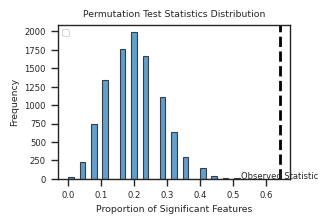

Observed Test Statistic (Proportion of Significant Features): 0.6400000000
P-value: 0.0000000000


In [10]:
# observed_test_statistic = top50_df.loc[top50_df['Category'].isin(['Significant_Positive', 'Significant_Negative']), 'Proportion'].sum() # from 
print(observed_test_statistic)
combined_size = 660

num_gen_features = 635
num_top_features = 25

significant_count_top50 = int((top50_significant_positive_count + top50_significant_negative_count) / top50_total_features * num_top_features)
print(f"significant_count_top50: {significant_count_top50}")

non_significant_count_top50 = num_top_features - significant_count_top50
print(f"non_significant_count_top50: {non_significant_count_top50}")

significant_count_general = int((general_significant_positive_count + general_significant_negative_count) / general_total_features * num_gen_features)
print(f"significant_count_general: {significant_count_general}")

non_significant_count_general = num_gen_features - significant_count_general
print(f"non_significant_count_general: {non_significant_count_general}")

combined_data = np.concatenate((
    np.repeat(1, significant_count_general), 
    np.repeat(0, non_significant_count_general), 
    np.repeat(1, significant_count_top50), 
    np.repeat(0, non_significant_count_top50) 
))
print(len(combined_data))

n_permutations = 10000
perm_proportions = []

for _ in range(n_permutations):
    sample = np.random.choice(combined_data, size=25, replace=True) 
    sample_significant_proportion = np.mean(sample)
    perm_proportions.append(sample_significant_proportion)

perm_proportions = np.array(perm_proportions)

plt.figure(figsize=(3, 2))
plt.hist(perm_proportions, bins=30, edgecolor='k', alpha=0.7)
plt.axvline(observed_test_statistic, color='black', linestyle='dashed', linewidth=2)
#plt.plot([observed_test_statistic, observed_test_statistic], [0, 15], color='black', linewidth=2)
plt.text(observed_test_statistic, 0.05, 'Observed Statistic', horizontalalignment='center', fontsize=6)

plt.title('Permutation Test Statistics Distribution')
plt.xlabel('Proportion of Significant Features')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("/sc/arion/work/kimg20/aging/ml/figures6c_supp.pdf", format="pdf")

plt.show()
p_value = np.mean(perm_proportions >= observed_test_statistic)

print(f"Observed Test Statistic (Proportion of Significant Features): {observed_test_statistic:.10f}")
print(f"P-value: {p_value:.10f}")

### S6C